# Intro to Regression

We're going to go through a few regression exercises that will help you better see how regression might work in action in Python.  

## Learning Goals
The packages and techniques we'll hope to get comfortable with in this activity are the following:
- [***statsmodels***](http://statsmodels.sourceforge.net/): a package mainly best at doing regressions with traditional R formula syntax
- [***R formulas***](http://science.nature.nps.gov/im/datamgmt/statistics/r/formulas/): R formulas are a convenient way for encapsulating functional relationships for regressions
- [***seaborn***](http://stanford.edu/~mwaskom/software/seaborn/): We'll use seaborn for **visualization** as we go along
- [***scikit-learn***](http://scikit-learn.org/dev/index.html): This is the main machine learning package we'll be using throughout the course.  It has a multitude of machine learning algorithms and helpful machine learning pipeline tools.  sklearn has a tremendous amount of functionality, to get the most out of this course it will help to really explore the depth of the documentation on your own and watch as you understand more and more of the functionality as the course progresses.
- [***Linear Regression***](http://scikit-learn.org/stable/modules/linear_model.html) with scikit-learn:  We'll work with the basic linear regression module(s)
- [***Variable Preprocessing and Polynomial Regression***](http://scikit-learn.org/dev/modules/preprocessing.html#preprocessing) with scikit-learn:  We'll be **"standardizing"** or **"normalizing"** many of our variables to yield better model data.  We'll show how the "linear" models can be extended to basically any type of function by using functions of the different fields as the inputs to the linear model.
- [***Regularization and Cross-Validation***](http://scikit-learn.org/dev/model_selection.html#model-selection): This is how you know if your model will **generalize** to real-world data and how you evaluate the success of your model.  We will see more on **cross-validation** to come so we'll take it as given today.  Today, the focus is on **regularization**.

## Datasets
We'll take a look at a few different datasets:
1. [Survey Responses](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) (done together)
2. Manufactured random dataset  (done together)
3. [Bike sharing dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) (exercise, in pairs)

## Setup
Try running the following imports and check that they all import successfully.  If they do not, the commands for the installs are given below.  If necessary, at a command line window use `pip` to install the ones that are failing for you and then retry the imports.

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import cPickle as pickle
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

### Installations (if necessary)
<pre><code>pip install pandas</code></pre>
<pre><code>pip install numpy</code></pre>
<pre><code>pip install statsmodels</code></pre>
<pre><code>pip install seaborn</code></pre>
<pre><code>pip install scikit-learn</code></pre>

## Survey Data
We will use this [simple survey data](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) to demonstrate a few basic features of ***statsmodels*** and ***seaborn*** and how they might be used in a data science workflow for regression.

The dataset is simply the results of a survey where the question responses are all numeric.  This leads to 6 numeric independent variable (predictor) fields and 1 numeric dependent variable (response) field.  The predictors are labeled ***X<sub>i</sub>*** and the response is labeled ***Y***.

Let's load the dataset in using ***pandas*** and take a look at it.  Here we use [***pandas.read_table***](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) to load the data.

In [2]:
# Load the data in
df = pd.read_table('http://www.ats.ucla.edu/stat/examples/chp/p054.txt')
# Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
Y      30 non-null int64
X1     30 non-null int64
X2     30 non-null int64
X3     30 non-null int64
X4     30 non-null int64
X5     30 non-null int64
X6     30 non-null int64
dtypes: int64(7)
memory usage: 1.7 KB


In [3]:
# Take a look at the first few rows
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


If we look at the column names, we'll notice we have the trailing whitespace problem again.

In [4]:
df.columns

Index([u'Y ', u'X1 ', u'X2 ', u'X3 ', u'X4 ', u'X5 ', u'X6 '], dtype='object')

We can remove this by calling map on the columns list and stripping the whitespace with strip.  The ***map*** function is applied to Series objects, whereas the ***apply*** and ***applymap*** functions are called on Dataframes.

In [5]:
df.columns = df.columns.map(str.strip)
df.columns

Index([u'Y', u'X1', u'X2', u'X3', u'X4', u'X5', u'X6'], dtype='object')

In [6]:
# How many rows and columns does the dataset have?
df.shape

(30, 7)

### Visualizing with Seaborn
We see that the data has 30 responses with 7 fields (6 independent, 1 dependent) each.  Let's use pandas to check out the correlations between the different variables.

In [7]:
# View the correlations
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.825418,0.426117,0.623678,0.590139,0.156439,0.155086
X1,0.825418,1.000000,0.558288,0.596736,0.669197,0.187714,0.224580
X2,0.426117,0.558288,1.000000,0.493331,0.445478,0.147233,0.343293
X3,0.623678,0.596736,0.493331,1.000000,0.640314,0.115965,0.531620
X4,0.590139,0.669197,0.445478,0.640314,1.000000,0.376883,0.574186
X5,0.156439,0.187714,0.147233,0.115965,0.376883,1.000000,0.283343
X6,0.155086,0.224580,0.343293,0.531620,0.574186,0.283343,1.000000


#### Correlation and Multicollinearity
We notice that some of the variables are highly correlated.  This is something we might want to take into consideration later.  When 2 predictor variables are highly correlated this is called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and it is something we want to watch out for as it can destabilize our model.  In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.

The other takeaway from this table is that some of our predictors are highly correlated with our ***target variable Y***.  This is a good thing, it means that these are the variables that we most likely want to include as part of our model as they explain a large amount of the variance in the target variable (correlation=R, variance_explained=R<sup>2</sup>).

Let's try to visualize these correlations all together by using the [***seaborn pairplot***](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html) function.  What do you notice?

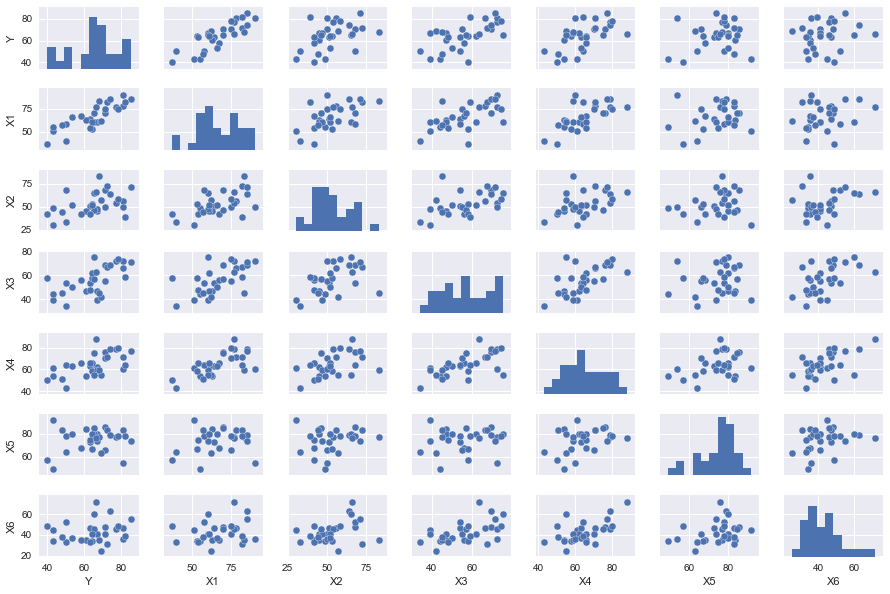

In [8]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df, size = 1.2, aspect=1.5)

### Ordinary Least Squares Regression with Statsmodels
Now that we have a feel for our data, let's jump right in and try a basic regression model.  

#### Statsmodels
We are going to use the [**`statsmodels`**](http://statsmodels.sourceforge.net/) library first.  `statsmodels` is a Python package for implementing [**linear models**](https://en.wikipedia.org/wiki/Linear_model), of which **Linear Regression** is one.  It has a bunch of nice features for evaluating and executing such models.  Essentially, a linear model is one that is a **linear function of the parameters**.  For Linear Regression, this means the parameter $\beta$ (note that here $\beta$ is a **vector** of parameters, which includes $\beta_0$, $\beta_1$, $\beta_2$, etc).  We'll discuss linear models generally later but for  now just accept that Linear Regression is one of these.

#### Modeling with Statsmodels
There are 2 main ways you can generate models with stats models:
- Via the `statsmodels.api` package
- Via the `statsmodels.formula.api` package

For both approaches, you'll need somewhere to use the [R formula](http://science.nature.nps.gov/im/datamgmt/statistics/r/formulas/) styles formulas for defining the relationship between target variable and feature variables in your model.  ***Statsmodels*** uses [***patsy***](http://patsy.readthedocs.org/en/latest/) to convert this syntax into the proper data matrices for input into its linear models under the covers.  There are a variety of interactions and functions of variables that you can incorporate with this syntax, so feel free to check out the docs.

Here we'll just start by defining a regression model that takes as its inputs each of the 6 predictor variables.  The other parameter of course is the data that the model is to be built from, our pandas dataframe.

This first model fitting is done for you, it fits a multiple linear regression model of the following form (notice the use of [MathJax](https://www.mathjax.org/) for rendering such lovely math equations in markdown):

$$
Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \beta_6X_6
$$

##### `statsmodels.api`
To use this method, you need to generate a **matrix** of **features**, **`X`** and a **vector** of **targets**, **`y`** where each row represents a single **observation**.  In statsmodels, you can do this with a call to **`patsy.dmatrices`**:


In [9]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           1.24e-05
Time:                        16:01:56   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362       -13.187    34.761
X1             0.6132      0.161      3.809      0.001         0.280     0.946
X2            -0.0731      0.136     -0.538      0.596        -0.354     0.208
X3             0.3203      0.169      1.901      0.070        -0.028     0.669
X4             0.0817      0.221      0.369      0.715        -0.376     0.540
X5             0.0384      0.147      0.261      0.796        -0.266     0.342
X6            -0.2171      0.178     -1.218      0.236        -0.586     0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### `statsmodels.formula.api`
The formula approach handles the creation of the `X` and `y` matrices internally, so all you have to do is supply the R formula for your model when you create your `ols` object.  

**NOTE:** We'll use this for the remainder of these exercises, but many people like to stick with the `dmatrices` and `X`, `y` matrix creation approach because that is the way `sklearn` works (see later).  Notice that here we've built the same model and it's deterministic, so the results are the same.

In [10]:
# Define the model
lm1 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           1.24e-05
Time:                        16:01:56   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362       -13.187    34.761
X1             0.6132      0.161      3.809      0.001         0.280     0.946
X2            -0.0731      0.136     -0.538      0.596        -0.354     0.208
X3             0.3203      0.169      1.901      0.070        -0.028     0.669
X4             0.0817      0.221      0.369      0.715        -0.376     0.540
X5             0.0384      0.147      0.261      0.796        -0.266     0.342
X6            -0.2171      0.178     -1.218      0.236        -0.586     0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Regression Statistics
From this we get a handful of useful statistics describing our regression.  A quick google search on any should yield details for those interested.  We will focus on the ***R<sup>2</sup>*** values and the middle table here.

***R<sup>2</sup>*** is the square of the correlation coefficient and represents the estimated percentage of the variance in our target variable ***Y*** that can be explained by our regression model.  ***Adjusted R<sup>2</sup>*** also penalizes for things such as large coefficients and extra variables to try and limit ***overfitting*** so it is often a better measure of model efficacy.  We will use that here.

The middle table provides the **coefficients** that are regression has found, along with the **standard error** for each coefficient.  This defines our model, aka these are the model parameters that our algorithm was seeking to determine.  

The **t-scores** are values that the coefficients score in the [Student's T Distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) and the **P(|t|)** field represents the probability of finding such a t-score if the actual value of the coefficient were 0.  In other words, if we had a coefficient whose true value should be 0 (aka the predictor has no impact on the response) then this P-value is the probability of finding such a coefficient value in our regression by random chance.  In essence, it measures our degree of belief that the coefficient for each variable should be zero.  Thus, the lowest P-values represent the most likely predictors to be impacting the response.

Putting it all together, the final column returns a **95% Confidence Interval** for the value of each coefficient.

Given these stats, lets remove the highest 3 P-values from our regression model, from ***X<sub>2</sub>***, ***X<sub>4</sub>***, and ***X<sub>5</sub>*** and see how our model performs now:

In [11]:
df2 = df.drop(df.columns[[2, 4, 5]], axis=1)

lm1 = smf.ols('Y ~ X1 + X3 + X6', data=df2)
# Fit the model
fit2 = lm1.fit()
# Print summary statistics of the model's performance
fit2.summary()
# Fit the model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     22.92
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           1.81e-07
Time:                        16:01:56   Log-Likelihood:                -97.638
No. Observations:                  30   AIC:                             203.3
Df Residuals:                      26   BIC:                             208.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.5777      7.544      1.800      0.084        -1.929    29.084
X1             0.6227      0.118      5.271      0.000         0.380     0.866
X3             0.3124      0.154      2.026      0.053        -0.005     0.629
X6            -0.1870      0.145     -1.291      0.208        -0.485     0.111
==============================================================================
Omnibus:                        2.856   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                1.394
Skew:                          -0.121   Prob(JB):                        0.498
Kurtosis:                       1.972   Cond. No.                         605.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You should see our **Adjusted R<sup>2</sup>** has increased, and our P-values are lower so we likely have a better model.  Let's just try removing ***X<sub>6</sub>*** to see if that might improve our model a little bit more.

In [12]:
# STUDENT SECTION
# Define the model removing X6 this time
# Define the model
lm1 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5', data=df)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()
# Fit the model

# Check out the results


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     12.06
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           6.50e-06
Time:                        16:01:56   Log-Likelihood:                -98.187
No. Observations:                  30   AIC:                             208.4
Df Residuals:                      24   BIC:                             216.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     11.0111     11.704      0.941      0.356       -13.145    35.167
X1             0.6921      0.149      4.649      0.000         0.385     0.999
X2            -0.1036      0.135     -0.769      0.450        -0.382     0.175
X3             0.2491      0.160      1.560      0.132        -0.080     0.578
X4            -0.0335      0.202     -0.165      0.870        -0.451     0.384
X5             0.0155      0.147      0.105      0.917        -0.288     0.319
==============================================================================
Omnibus:                        4.289   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                1.626
Skew:                           0.002   Prob(JB):                        0.444
Kurtosis:                       1.860   Cond. No.                     1.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nope, both **R<sup>2</sup>** coefficients decreased so lets stick with the 2nd model.

### Plotting Residuals
Before we call it a day with this model and dataset, let's take a quick look at a plot of our residuals *(actual value - predicted value)* with this model.  We do this because in a good model we essentially want our errors to be random.  If our residuals look systematic (e.g. missing high for one range and low for another) then we probably are missing the actual functional dependency underlying the data (perhaps it's not really linear).

Take a look [here]([a bad residue plot](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) for an example of a bad residual plot.

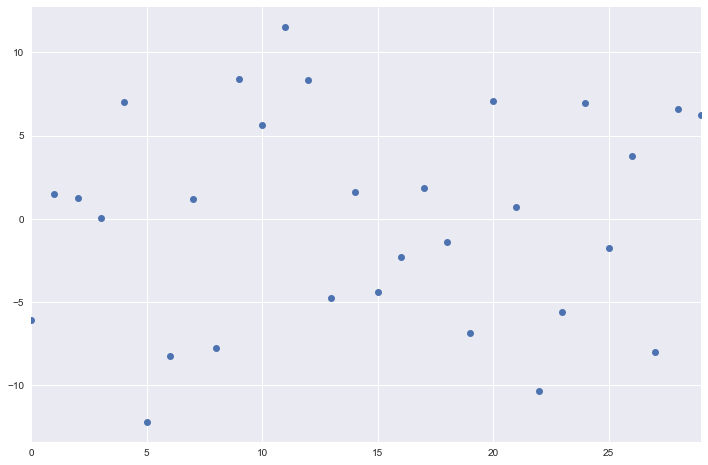

In [13]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8))

Nope this looks pretty random to me!  So let's move on to some more interesting modeling functions with sklearn!

## Regression and Polynomial Regression with sklearn
Statsmodels has decent functionality for linear models, but scikit-learn has a massive amount of modeling options for all sorts of algorithms as well as data preparation and is growing every day, so we will generally be working with that from here on.

### Regression with sklearn
Before we jump into some of the additional features of sklearn, let's try to repeat our basic survey example using sklearn's built in **LinearRegression**.

You should still have your Dataframe loaded from earlier.  Let's try repeating some of the different models we tried earlier with sklearn.  Here's the first model:

In [14]:
# Create an empty model
lr = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:, 1:]
# Choose the response variable(s)
y = df.iloc[:, 0]
# Fit the model to the full dataset
lr.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.7326019925311491

If you look back you'll notice that this is the same **R<sup>2</sup>** value that was reported for the first model above.  Let's quickly run the best model from earlier (***X1***, ***X3***, and ***X6***) and see how it performs.

In [15]:
# STUDENT SECTION
# Create an empty model
lr1 = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['X1', 'X3', 'X6']]
# Choose the response variable(s)
Y = df[['Y']]
# Fit the model to the full dataset
lr1.fit(X, y)
# Print out the R^2 for the model against the full dataset
lr1.score(X,y)

0.72559499957450724

Notice that the **R<sup>2</sup>** value is the same again.  It's slightly lower, the same as we saw earlier, but the **Adjusted R<sup>2</sup>** value that we saw earlier was higher for this one.  

So we've seen how can do simple models with statsmodels and sklearn, but what does anyone see an issue with what we've done here?  What data have we fit and scored our models on?  What claims can we make about the probable performance of our model going forward?

### sklearn: What's in a model?
Essentially all models in `sklearn` inherit from the same type of "estimator" interface.  This means they'll share common methods that we'll see over and over again like:
- `fit()`: Fit a model to a set of training data
- `score()`: Score the performance of a model on a given sample of data with known ground truth dependent variables
- `predict()`: Predict target/response variables based on a sample of independent variables (features, predictors, etc)

Additionally, models are usually loaded with other goodies once they've been fit, which can provide information about the resulting fitted model.  For instance, the following might be of interest in regression:
- `intercept_`: our $\beta_0$ intercept in our regression model
- `coef_`: the other $\beta$s in our model

Let's print those out:

In [16]:
# STUDENT SECTION
# print out intercept
lr1.intercept_
# print out other coefficients
lr1.coef_

array([ 0.62272975,  0.31238698, -0.18695081])

##### Pickling for Later
We're going to come back to this dataset!  So let's pickle it away for later...

`sklearn`, `pandas` and `statsmodels` have their own respective methods for "pickling" their objects.

**Pandas:**

To pickle a `pandas.DataFrame` use the [`to_pickle()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html) method.  Use this now to pickle your training data `df` now.

In [17]:
# Pickle your pandas dataframe
df.to_pickle('data/survey_data.pkl')

**Statsmodels**

To pickle a statsmodels object us the [`save()`](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLSResults.save.html#statsmodels.regression.linear_model.OLSResults.save) method.  Use this to pickle your best fit model `fit2` to `survey_sm_model.pkl` now.

In [18]:
# Pickle fit2 to a file 
fit2.save('data/survey_sm_model.pkl')

**sklearn**

Pickle an `sklearn` model to the file `survey_sk_model.pkl` using the `sklearn` replacement for pickle `joblib` as seen [here](http://scikit-learn.org/stable/modules/model_persistence.html).

In [19]:
from sklearn.externals import joblib
joblib.dump(lr, 'data/survey_sk_model.pkl')

['data/survey_sk_model.pkl']

### Polynomial Regression
So far we've only tried to create regression models that are linear functions of the predictor variables.  However, there's no reason we can't transform the predictor variables by any type of function we want before inputting them to linear regression.  This is the idea behind [**Polynomial Regression**](https://en.wikipedia.org/wiki/Polynomial_regression) and it allows us (along with similar functional regressions) to essentially model our response variables as any function of our predictor variables that we like.  Viewed in this way, Linear Regression is just a special instance of Polynomial Regression with a polynomial of degree 1.

#### Polynomial Regression with sklearn
sklearn has built-in options for converting your predictor variables to polynomial functions of them.  In this exercise we'll use the [**PolynomialFeatures**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class of sklearn to manipulate incoming predictors into nth-order polynomials of those features.  We'll combine this with the [***make_pipeline***](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function to string together a pipeline of operations that is able to first transform our linear features into polynomial features and then run a linear regression against the resulting polynomial features. 

##### Generating Random Data
The first thing we're going to do is manufacture some data from a known distribution with a little additive noise.  This allows us to compare our results to the known ground truth.  Let's create that data from a sine curve as follows:

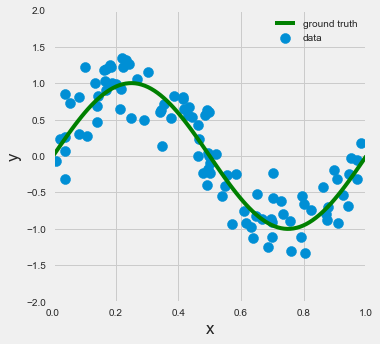

In [20]:
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

# We start by seeding the random number generator so that everyone will have the same "random" results
np.random.seed(9)

# Function that returns the sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
# This returns 100 evenly spaced numbers from 0 to 1
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
# Generate the x values from the random uniform distribution between 0 and 1
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1)
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X, y, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

##### Fitting an nth-degree Polynomial
Now that we have our data and know the ground truth, let's try fitting a 3rd degree polynomial to our training data and see how it looks.  3rd degree makes sense for this interval because the sin function has 2 turning points over the interval [0,1] and a 3rd degree polynomial will general have 2 (or less) turning points.

We first define a function `plot_approximation` that takes a pipeline of steps from make_pipeline and some plotting info and will plot the results of the sklearn pipeline on the specified plot with the ground truth and data in the background.

In [21]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

Now let's generate our pipeline for a 3rd degree polynomial and try it out in our plotting function.  Note that the steps are:
- Use PolynomialFeatures(3) to create a generator of 3rd degree polynomials
- Feed this generator to make_pipeline along with a LinearRegression object to tell it to string together these operations when given a new set of input predictor variables.  This results in a new model object that has the same `fit()`, `score()`, `predict()`, etc functions
- Call `fit()` on our new object to fit a 3rd degree polynomial regression
- Send the result to our plotting function to view the results

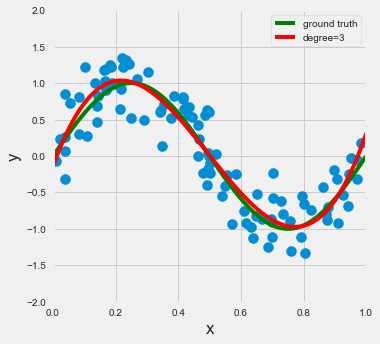

In [22]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 3
# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

**Q: Qualitatively**, how would you characterize this fit?

Plot the fit of a polynomial of degree 2:

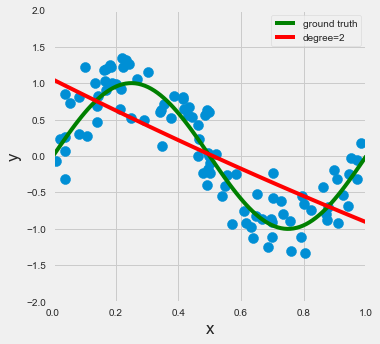

In [23]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 2
# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

Plot the fit of a polynomial of degree 9, or heck, how bout 27!?:

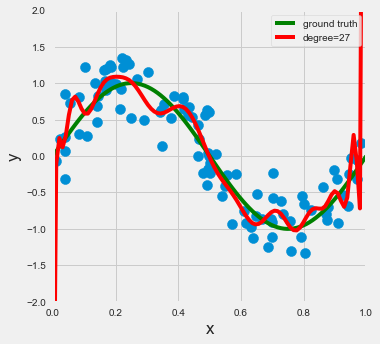

In [24]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 27
# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)

**Q: What happens as we increase the degree of polynomial?**

**Q: Which polynomial should we choose?**

To gain some insight into this, let's plot polynomials from degree 1 to 9 and examine how the errors in our predictions change vs. the training and test sets.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


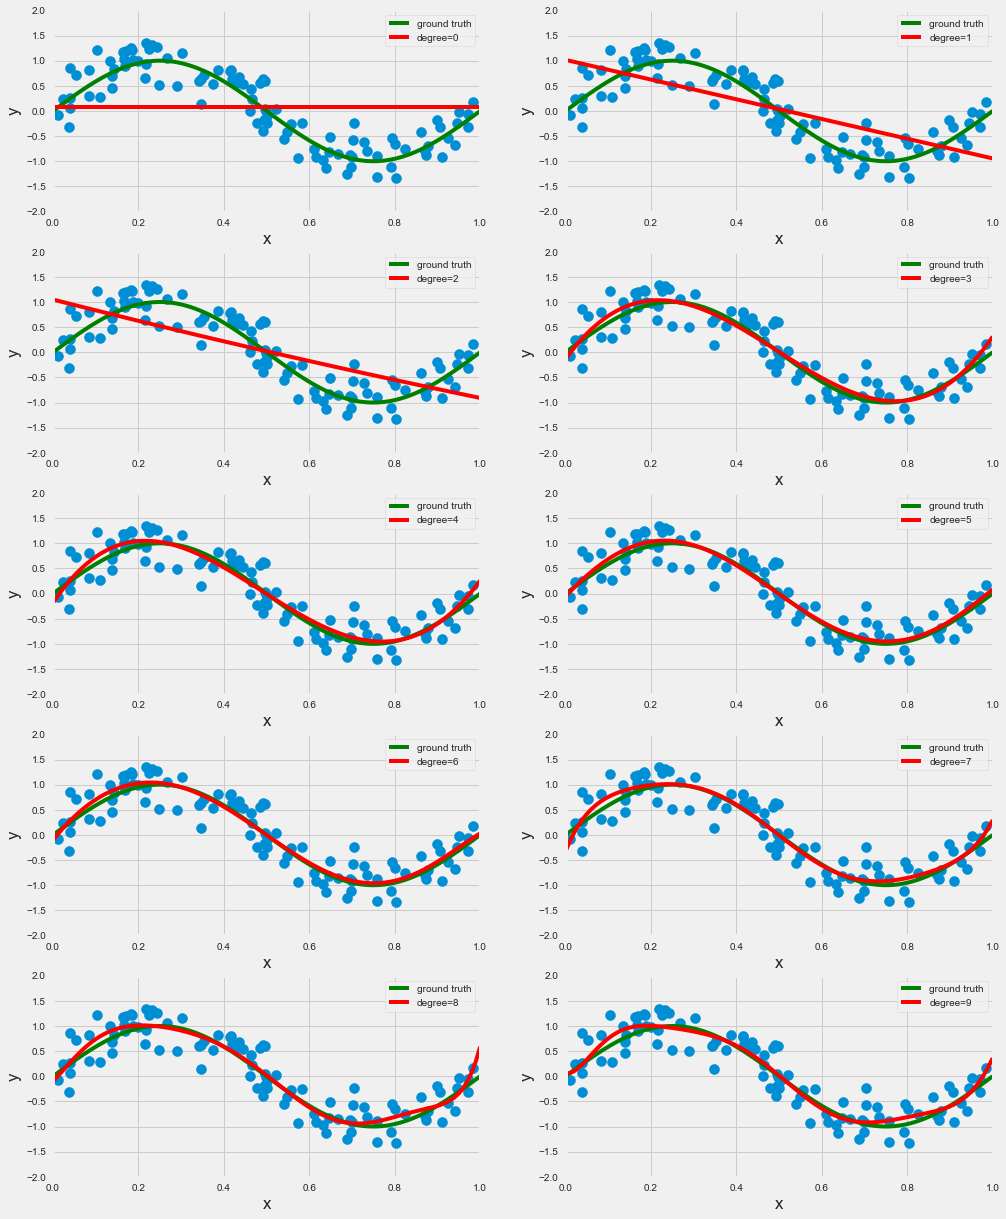

In [25]:
# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# This sets up 5 rows of 2 plots each (KEEP)
fig, ax_rows = plt.subplots(5, 2, figsize=(15, 20))
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[degree/2]
    if degree%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(est, ax, label='degree=%d' % degree)

**What do you notice?**

##### Pickling for later
We may return to this fake data for further exploration later, so let's pickle our `X` and `y` so we can do just that.  To save `numpy` arrays, you use the [`numpy.save()`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.save.html) method.  We can save multiple arrays to one file with the [`numpy.savez()`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.savez.html) method.  Use this now to save `X` and `y` to the file `poly_data.npz`.

In [26]:
# Pickle the numpy arrays X and y
np.savez('data/poly_data.npz', X, y)

## Exercises: Car Price Predictor Dataset
For these exercises we'll be exploring the auto data available [here](https://archive.ics.uci.edu/ml/datasets/Automobile).  The goal is to be able to predict auto price from the 

#### Data Exploration
##### Read the data in
Use pandas `read_csv()` to load the data into a dataframe and then call `head()` to make sure everything looks good.

In [27]:
# read in the car dataset
df=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data',header=None)

columns= ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
df.columns=columns
# Use head to view the first few rows
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Use [`shape`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html#pandas.DataFrame.shape) to check out how many rows and columns the dataframe has.

In [28]:
# STUDENT SECTION
# How many rows and columns do we have? 
df.shape

(205, 26)

Use [`info()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html#pandas.DataFrame.info) to get a summary of the dataframe and its datatypes

In [29]:
# STUDENT SECTION
# Let's examine the datatypes
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


**Lets keep numeric data ** 
- Create a list of columns to keep
- Select out only those columns from the dataframe and reassign the dataframe to that selection
- Use `head()` & `info()` to make sure everything worked as expected

In [30]:
# STUDENT SECTION
# Create a list of columns to keep

cars = df.loc[:,[u'symboling', u'normalized-losses', u'num-of-doors', u'wheel-base', 
            u'length', u'width', u'height', u'curb-weight', u'num-of-cylinders', 
            u'engine-size', u'bore', u'stroke', u'compression-ratio', u'horsepower',
            u'peak-rpm', u'city-mpg', u'highway-mpg', u'price']]
cars.head()
cars.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 18 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
num-of-doors         205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-null object
peak-rpm             205 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                205 non-null object
dtypes: float64(5), int64(5), object(8)
memory usage: 28.9+ KB


It looks like some of our features (even our targe feature :'price') is listed as an object.    
Run cars.head(10), and we will see why!  

In [31]:
cars.head(10)

,symboling,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,two,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,two,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,two,94.5,171.2,65.5,52.4,2823,six,152,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,four,99.8,176.6,66.2,54.3,2337,four,109,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,four,99.4,176.6,66.4,54.3,2824,five,136,3.19,3.40,8.0,115,5500,18,22,17450
5,2,?,two,99.8,177.3,66.3,53.1,2507,five,136,3.19,3.40,8.5,110,5500,19,25,15250
6,1,158,four,105.8,192.7,71.4,55.7,2844,five,136,3.19,3.40,8.5,110,5500,19,25,17710
7,1,?,four,105.8,192.7,71.4,55.7,2954,five,136,3.19,3.40,8.5,110,5500,19,25,18920
8,1,158,four,105.8,192.7,71.4,55.9,3086,five,131,3.13,3.40,8.3,140,5500,17,20,23875
9,0,?,two,99.5,178.2,67.9,52.0,3053,five,131,3.13,3.40,7.0,160,5500,16,22,?


In [32]:
# STUDENT SECTION : replace "?" data in order to turn our features into numerics
pd.set_option('display.max_rows', 1000)

num_dict = {"zero": int(0), "one": int(1), "two": int(2), "three": int(3), 
            "four": int(4), "five": int(5), "six": int(6), "eight": int(8), "twelve": int(12)}

cars['price'] = cars['price'].map(lambda x: int(x) if x != "?" else x)
cars['norm_losses'] = cars['normalized-losses'].map(lambda x: int(x) if x != "?" else x)
cars['bore'] = cars['bore'].map(lambda x: float(x) if x != "?" else x)
cars['stroke'] = cars['stroke'].map(lambda x: float(x) if x != "?" else x)
cars['horsepower'] = cars['horsepower'].map(lambda x: int(x) if x != "?" else x)
cars['peak_rpm'] = cars['peak-rpm'].map(lambda x: int(x) if x != "?" else x)
cars['city_mpg'] = cars['city-mpg'].map(lambda x: int(x) if x != "?" else x)
cars['highway_mpg'] = cars['highway-mpg'].map(lambda x: int(x) if x != "?" else x)
cars['compression_ratio'] = cars['compression-ratio'].map(lambda x: float(x) if x != "?" else x)
cars['wheel_base'] = cars['wheel-base']
cars['curb_weight'] = cars['curb-weight']
cars['engine_size'] = cars['engine-size']

cars.replace("?", np.nan, inplace=True)
cars.fillna(cars.mean(), inplace=True)

num_doors = cars['num-of-doors'].map(num_dict)
cars['num_doors'] = num_doors

num_cyl = cars['num-of-cylinders'].map(num_dict)
cars['num_cyl'] = num_cyl
cars.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 28 columns):
symboling            205 non-null int64
normalized-losses    164 non-null object
num-of-doors         203 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
bore                 205 non-null float64
stroke               205 non-null float64
compression-ratio    205 non-null float64
horsepower           205 non-null float64
peak-rpm             203 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                205 non-null float64
norm_losses          205 non-null float64
peak_rpm             205 non-null float64
city_mpg             205 non-null int64
highway_mpg          205 non-

We can see from the above output, that only a few entries where unknown in the first place.   
To keep things simple for now, lets just go ahead and drop the entries that were unknown: 


Before we begin modeling, use the [`corr()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html#pandas.DataFrame.corr) function to get a feel for the correlations among the different variables, especially with regard to 'price'.

In [33]:
del cars['curb-weight']
del cars['engine-size']
del cars['highway-mpg']
del cars['city-mpg']
del cars['compression-ratio']
del cars['num-of-cylinders']
del cars['peak-rpm']
del cars['normalized-losses']
del cars['wheel-base']
del cars['num-of-doors']

In [34]:
cars.corr()

,symboling,length,width,height,bore,stroke,horsepower,price,norm_losses,peak_rpm,city_mpg,highway_mpg,compression_ratio,wheel_base,curb_weight,engine_size,num_doors,num_cyl
symboling,1.000000,-0.357612,-0.232919,-0.541038,-0.130083,-0.008689,0.071389,-0.082201,0.465190,0.273679,-0.035823,0.034606,-0.178515,-0.531954,-0.227691,-0.105790,-0.664550,-0.113129
length,-0.357612,1.000000,0.841118,0.491029,0.606462,0.129522,0.554434,0.682986,0.019209,-0.287031,-0.670909,-0.704662,0.158414,0.874587,0.877728,0.683360,0.393593,0.430672
width,-0.232919,0.841118,1.000000,0.279210,0.559152,0.182939,0.642195,0.728699,0.084195,-0.219859,-0.642704,-0.677218,0.181129,0.795144,0.867032,0.735433,0.202072,0.545007
height,-0.541038,0.491029,0.279210,1.000000,0.171101,-0.055351,-0.110137,0.134388,-0.370706,-0.320602,-0.048640,-0.107358,0.261214,0.589435,0.295572,0.067149,0.547651,-0.013995
bore,-0.130083,0.606462,0.559152,0.171101,1.000000,-0.055909,0.575737,0.532300,-0.029266,-0.254761,-0.584508,-0.586992,0.005201,0.488760,0.648485,0.583798,0.113117,0.231439
stroke,-0.008689,0.129522,0.182939,-0.055351,-0.055909,1.000000,0.088264,0.082095,0.054929,-0.066844,-0.042179,-0.043961,0.186105,0.160944,0.168783,0.203094,-0.010654,0.008151
horsepower,0.071389,0.554434,0.642195,-0.110137,0.575737,0.088264,1.000000,0.757917,0.203434,0.130971,-0.803162,-0.770903,-0.205740,0.351957,0.750968,0.810713,-0.124320,0.691208
price,-0.082201,0.682986,0.728699,0.134388,0.532300,0.082095,0.757917,1.000000,0.133999,-0.100854,-0.667449,-0.690526,0.070990,0.583168,0.820825,0.861752,0.046051,0.687770
norm_losses,0.465190,0.019209,0.084195,-0.370706,-0.029266,0.054929,0.203434,0.133999,1.000000,0.237748,-0.218749,-0.178221,-0.114525,-0.056518,0.097785,0.110997,-0.362716,0.108081
peak_rpm,0.273679,-0.287031,-0.219859,-0.320602,-0.254761,-0.066844,0.130971,-0.100854,0.237748,1.000000,-0.113723,-0.054257,-0.435936,-0.360704,-0.266283,-0.244599,-0.241249,-0.124358


Take a look at only the 'price' column of the correlations and order it in descending order wih [`sort_values()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html#pandas.DataFrame.sort_values)

In [35]:
# STUDENT SECTION
# Get the correlations with 'price' sorted in descending order

cars.corr()['price'].sort_values(ascending=False)

price                1.000000
engine_size          0.861752
curb_weight          0.820825
horsepower           0.757917
width                0.728699
num_cyl              0.687770
length               0.682986
wheel_base           0.583168
bore                 0.532300
height               0.134388
norm_losses          0.133999
stroke               0.082095
compression_ratio    0.070990
num_doors            0.046051
symboling           -0.082201
peak_rpm            -0.100854
city_mpg            -0.667449
highway_mpg         -0.690526
Name: price, dtype: float64

In [36]:
del cars['peak_rpm']
del cars['num_doors']
del cars['symboling']
del cars['compression_ratio']
del cars['stroke']
del cars['norm_losses']
del cars['height']

In [37]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 11 columns):
length         205 non-null float64
width          205 non-null float64
bore           205 non-null float64
horsepower     205 non-null float64
price          205 non-null float64
city_mpg       205 non-null int64
highway_mpg    205 non-null int64
wheel_base     205 non-null float64
curb_weight    205 non-null int64
engine_size    205 non-null int64
num_cyl        205 non-null int64
dtypes: float64(6), int64(5)
memory usage: 17.7 KB


You should now have a better feel for which variables might be most valuable for your model.
Q :  Do correlations provide the 'entire picture' of what is happening with our model? 
A:  Nope. It can give us an idea : but corrs will only provide the relationship with the response variable (all other factors being held constant) 

Now use ***seaborn's*** `pairplot()` function to visualize these correlations for the variables.  What do you think of our distributions?

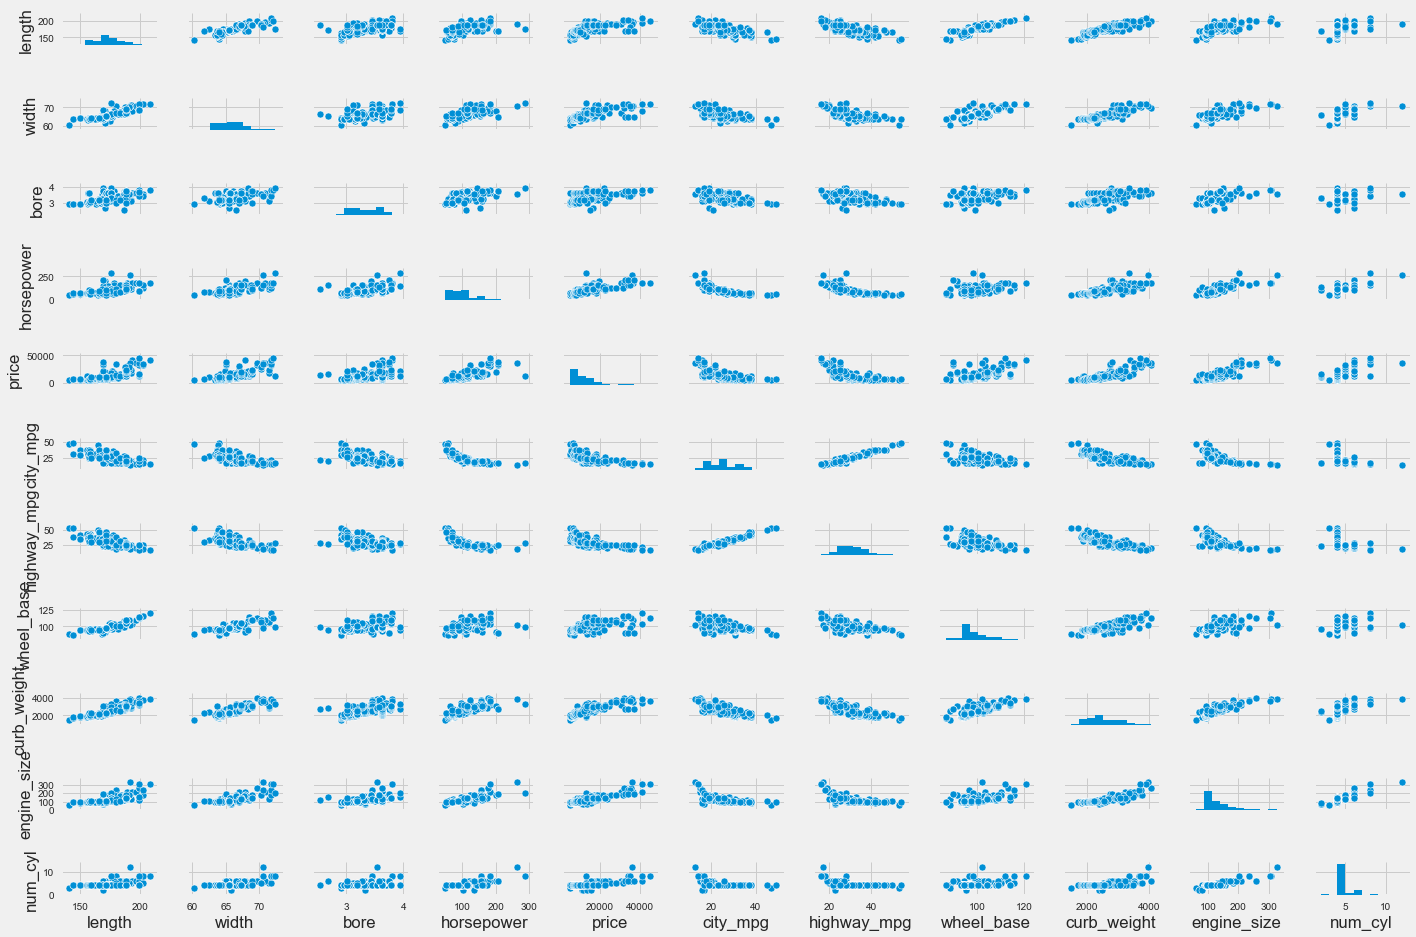

In [38]:
# STUDENT SECTION
#Let's try visualizing some of these pairwise correlations with seaborn

sns.pairplot(cars, size = 1.2, aspect=1.5)

#### Modeling with statsmodels
Let's try some exploration with statsmodels.  As a first model, try creating an ordinary least squares model with statsmodels by incorporating all of the variables that had at least a .10 absolute value of correlation with cnt above 
- Create your model with the `ols()` function with the appropriate **R Formula** syntax and your dataframe
- Fit the model
- Print the fit summary to check out the results

In [39]:
cars.columns

Index([     u'length',       u'width',        u'bore',  u'horsepower',
             u'price',    u'city_mpg', u'highway_mpg',  u'wheel_base',
       u'curb_weight', u'engine_size',     u'num_cyl'],
      dtype='object')

In [40]:
# DOUBLE CHECK TO MAKE SURE I WAS INCLUDING INTERCEPTS!@$!@$!$!!

# STUDENT SECTION
# Let's jump right in and try a model with statsmodels using all variables above .10 correlation
# lsm = smf.ols('price~ ....', data = cars)

# You might have issues with one of the features .. Fix that one 

# Define the model
lm1 = smf.ols('price ~ length + width + bore + horsepower + city_mpg + highway_mpg + wheel_base + curb_weight + engine_size + num_cyl', data=cars)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     69.86
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           7.81e-59
Time:                        16:02:26   Log-Likelihood:                -1972.9
No. Observations:                 205   AIC:                             3968.
Df Residuals:                     194   BIC:                             4004.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -1.764e+04   1.52e+04     -1.163      0.246     -4.75e+04  1.23e+04
length        -14.5308     63.189     -0.230      0.818      -139.157   110.096
width         247.5539    281.056      0.881      0.380      -306.764   801.871
bore        -2911.7831   1595.769     -1.825      0.070     -6059.066   235.500
horsepower     32.1349     17.638      1.822      0.070        -2.652    66.922
city_mpg       40.8435    205.905      0.198      0.843      -365.256   446.943
highway_mpg   -98.4174    187.881     -0.524      0.601      -468.969   272.134
wheel_base     79.9641    111.737      0.716      0.475      -140.412   300.340
curb_weight     2.1478      1.830      1.174      0.242        -1.461     5.757
engine_size   127.1504     22.692      5.603      0.000        82.396   171.904
num_cyl      -941.5988    621.244     -1.516      0.131     -2166.858   283.660
==============================================================================
Omnibus:                       33.168   Durbin-Watson:                   0.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.322
Skew:                           0.665   Prob(JB):                     1.48e-20
Kurtosis:                       5.987   Cond. No.                     1.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Seaborn for Exploring Distributions
Your **R<sup>2</sup>** should be .834, not bad.  That means we believe we can explain about 83.4% of the variance in price with this model.  

One thing we will be discussing next week is Linear Regression assumptions and one being: normal distribution of the predictor variable.  Perhaps you noticed from our pairplot above that our 'price' variable is skewed.  Transform the y variable and rerun your OLS model.  Are there any other variables we should transform, why? 


In [41]:
# STUDENT SECTION
cars['log_price'] = np.log(cars['price'])

# Define the model
lm1 = smf.ols('log_price ~ length + width + bore + horsepower + city_mpg + highway_mpg + wheel_base + curb_weight + engine_size + num_cyl', data=cars)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     86.41
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           6.30e-66
Time:                        16:02:27   Log-Likelihood:                 26.553
No. Observations:                 205   AIC:                            -31.11
Df Residuals:                     194   BIC:                             5.448
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.9295      0.881      7.866      0.000         5.192     8.667
length          0.0039      0.004      1.075      0.284        -0.003     0.011
width           0.0136      0.016      0.832      0.407        -0.019     0.046
bore           -0.1254      0.093     -1.353      0.178        -0.308     0.057
horsepower      0.0029      0.001      2.836      0.005         0.001     0.005
city_mpg       -0.0087      0.012     -0.728      0.468        -0.032     0.015
highway_mpg     0.0028      0.011      0.258      0.797        -0.019     0.024
wheel_base     -0.0003      0.006     -0.046      0.964        -0.013     0.013
curb_weight     0.0004      0.000      3.388      0.001         0.000     0.001
engine_size     0.0037      0.001      2.799      0.006         0.001     0.006
num_cyl        -0.0616      0.036     -1.706      0.090        -0.133     0.010
==============================================================================
Omnibus:                       24.245   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.955
Skew:                           0.607   Prob(JB):                     1.73e-10
Kurtosis:                       4.947   Cond. No.                     1.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### What can we do with this observation?
##### Indicator (Dummy) Variables
As a first attempt, let's try to create [***indicator variables***](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) Indicator variables are 0/1 binary variables that indicate whether a condition is met or not, and they are quite useful in regression as they have an easy conceptual understanding: a value of 1 for a given field increases the target variable by the amount of its model coefficient.  These are often useful when provided with categorical attributes.  Any field with n unique categorical values can be reformulated into n indicator variable fields where each represents whether or not that attribute value is present.

Let's see how to transform a categorical variable into a dummy variable..

In [42]:
# Let's add 'make'
print(df.make.value_counts())
print('\n')
print(len(df.make.value_counts()))

toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
subaru           12
volkswagen       12
volvo            11
peugot           11
dodge             9
bmw               8
mercedes-benz     8
plymouth          7
audi              7
saab              6
porsche           5
isuzu             4
chevrolet         3
alfa-romero       3
jaguar            3
renault           2
mercury           1
Name: make, dtype: int64


22


In [43]:

# Let's use patsy to convert the feature 'make' to categorical variables

In [44]:
X=patsy.dmatrix('make',data=df,return_type='dataframe')
X.head()

# Q for Students: What do you notice about the returned matrix ? 

,Intercept,make[T.audi],make[T.bmw],make[T.chevrolet],make[T.dodge],make[T.honda],make[T.isuzu],make[T.jaguar],make[T.mazda],make[T.mercedes-benz],...,make[T.nissan],make[T.peugot],make[T.plymouth],make[T.porsche],make[T.renault],make[T.saab],make[T.subaru],make[T.toyota],make[T.volkswagen],make[T.volvo]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# A:  A couple of things:  1) First of all, we've added an intercept (comes for free w/ patsy!)  
#  2) 2nd: our favorite 'make' ('alfo-romero' of course) is missing from the above matrix

## This is because patsy knows about (The Dummy Variable Trap)[http://www.algosome.com/articles/dummy-variable-trap-regression.html]
# The idea behind DVT: Take a categorical variable that has two outcomes (example: boy & girl for the feature 'sex) - 
# We only need one column: "Girl", we can obviously solve for 'Boy' given this column -- if we had 
# both columns, we would automatically introduce multicolinearity  -- this idea can be extended to categorical features with 
# 20+ categories ! 

In [46]:
# STUDENT SECTION
# Append the X matrix to your cars matrix

cars2=cars.join(X)

## Cool thing to note: even though cars & X are different lengths (due to our previous .dropna()) ~ 
# joins allows us to 'merge' on their common index 

In [47]:
## For fun, let's see a quick way to throw cars2 into a OLS model,

# sm (vs smf) allows for the following shortcut!
import statsmodels.api as sm

y = cars2.log_price
x=cars2.drop(['log_price','price'],1)

lsm = sm.OLS(y,x)
fit4 = lsm.fit()
fit4.summary()

#  Looks like 'make' gives our R-squared a boost

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     53.76
Date:                Fri, 27 Jan 2017   Prob (F-statistic):           4.75e-73
Time:                        16:02:28   Log-Likelihood:                 94.973
No. Observations:                 205   AIC:                            -125.9
Df Residuals:                     173   BIC:                            -19.61
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
length                    0.0008      0.004      0.233      0.816        -0.006     0.008
width                     0.0073      0.016      0.454      0.650        -0.024     0.039
bore                     -0.3401      0.117     -2.911      0.004        -0.571    -0.110
horsepower                0.0020      0.001      2.062      0.041      8.65e-05     0.004
city_mpg                 -0.0012      0.010     -0.112      0.911        -0.022     0.019
highway_mpg              -0.0049      0.010     -0.507      0.613        -0.024     0.014
wheel_base               -0.0027      0.006     -0.415      0.679        -0.015     0.010
curb_weight               0.0004    9.2e-05      4.029      0.000         0.000     0.001
engine_size               0.0058      0.001      4.276      0.000         0.003     0.009
num_cyl                  -0.1445      0.034     -4.255      0.000        -0.212    -0.077
Intercept                 9.1561      0.864     10.594      0.000         7.450    10.862
make[T.audi]              0.0691      0.132      0.523      0.602        -0.192     0.330
make[T.bmw]               0.3771      0.127      2.962      0.003         0.126     0.628
make[T.chevrolet]        -0.2255      0.155     -1.459      0.146        -0.531     0.080
make[T.dodge]            -0.3079      0.121     -2.548      0.012        -0.546    -0.069
make[T.honda]            -0.2326      0.117     -1.987      0.048        -0.464    -0.002
make[T.isuzu]             0.0754      0.137      0.550      0.583        -0.195     0.346
make[T.jaguar]           -0.1494      0.166     -0.898      0.371        -0.478     0.179
make[T.mazda]            -0.1202      0.115     -1.043      0.298        -0.348     0.107
make[T.mercedes-benz]     0.1641      0.152      1.079      0.282        -0.136     0.464
make[T.mercury]          -0.0654      0.213     -0.308      0.759        -0.485     0.354
make[T.mitsubishi]       -0.3553      0.113     -3.153      0.002        -0.578    -0.133
make[T.nissan]           -0.2173      0.111     -1.966      0.051        -0.436     0.001
make[T.peugot]           -0.1210      0.146     -0.826      0.410        -0.410     0.168
make[T.plymouth]         -0.3416      0.122     -2.794      0.006        -0.583    -0.100
make[T.porsche]           0.3455      0.144      2.405      0.017         0.062     0.629
make[T.renault]          -0.3509      0.158     -2.217      0.028        -0.663    -0.038
make[T.saab]             -0.0173      0.128     -0.135      0.893        -0.270     0.236
make[T.subaru]           -0.1565      0.134     -1.165      0.245        -0.422     0.109
make[T.toyota]           -0.2250      0.112     -2.007      0.046        -0.446    -0.004
make[T.volkswagen]       -0.1234      0.117     -1.056      0.293        -0.354     0.107
make[T.volvo]          

In [48]:
#  And this is just the beginning !
## We'll pick up where we left off here tomorrow :) 

#For now, let's pickle our dataframe
cars2.to_pickle('cars2frame.pkl')




## What have we done?
- Learned how to use statsmodels with R formula syntax for creating linear models
- Learned how to evaluate models in different ways (R^2, cross-validation)
- Understood linear and polynomial regression in sklearn, with cross-validation and regularization
- Used seaborn for visualizing relationships in data
- Used pandas for manipulating data as we move through our workflow
- Gotten a peak into a genuine data science workflow
- Seen how curiosity and creativity can yield big gains in a data science modeling pipeline

## Play Time
See if you can improve the model by trying out whatever methods you like!  